### ---------------------------------------------------------------------------------
# PREMIUM PREDICTION (final notebook): 
### ----------------------------------------------------------------------------------

# - Importing necessary libraries :

In [2]:
import warnings 
warnings.filterwarnings(action= 'ignore') 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# - Reading data:

In [3]:
train= pd.read_csv('train.csv') #reading the training set
test= pd.read_csv('test.csv')  #reading the testing set

# - Exploratory data analysis:

* ## distribution:

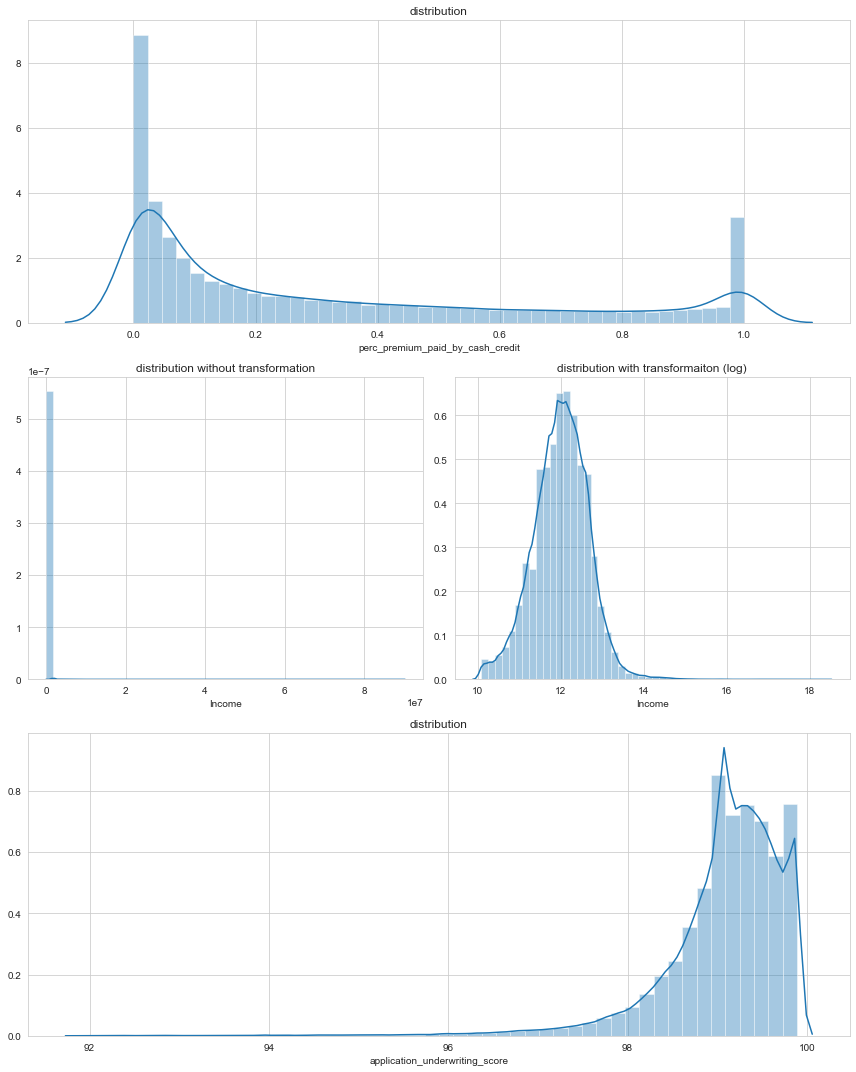

In [4]:
sns.set_style('whitegrid')
fig= plt.figure(figsize= (12,15))

ax1= fig.add_subplot(3,1,1)
ax2= fig.add_subplot(3,2,3)
ax3= fig.add_subplot(3,2,4)
ax4= fig.add_subplot(3,1,3)

train_= train.copy()
sns.distplot(train_['perc_premium_paid_by_cash_credit'],ax= ax1)
sns.distplot(train_['Income'],ax= ax2)
sns.distplot(np.log(train_['Income']),ax= ax3) #normalizing by taking log transformation
sns.distplot(train_['application_underwriting_score'].fillna(train_['application_underwriting_score'].mean()),ax= ax4)

ax1.set_title('distribution')
ax2.set_title('distribution without transformation')
ax3.set_title('distribution with transformaiton (log)')
ax4.set_title('distribution')

plt.tight_layout()
plt.show()

__from the above distributions we can infer that:__ 
* *the __perc_premium_paid_by_cash_credit__ feature is highly skewed for 0 and 1.0 values hence we can consider 'bagging' against these values*
* *the __income__ feature can be transformed by a log transformation to remove skewness*
* *the __application_underwriting_score__ feature has high left skewness, hence we can bag it against the values about 97.0 (as transforming was not effective)*

* ## univariate and bivariate analysis: 

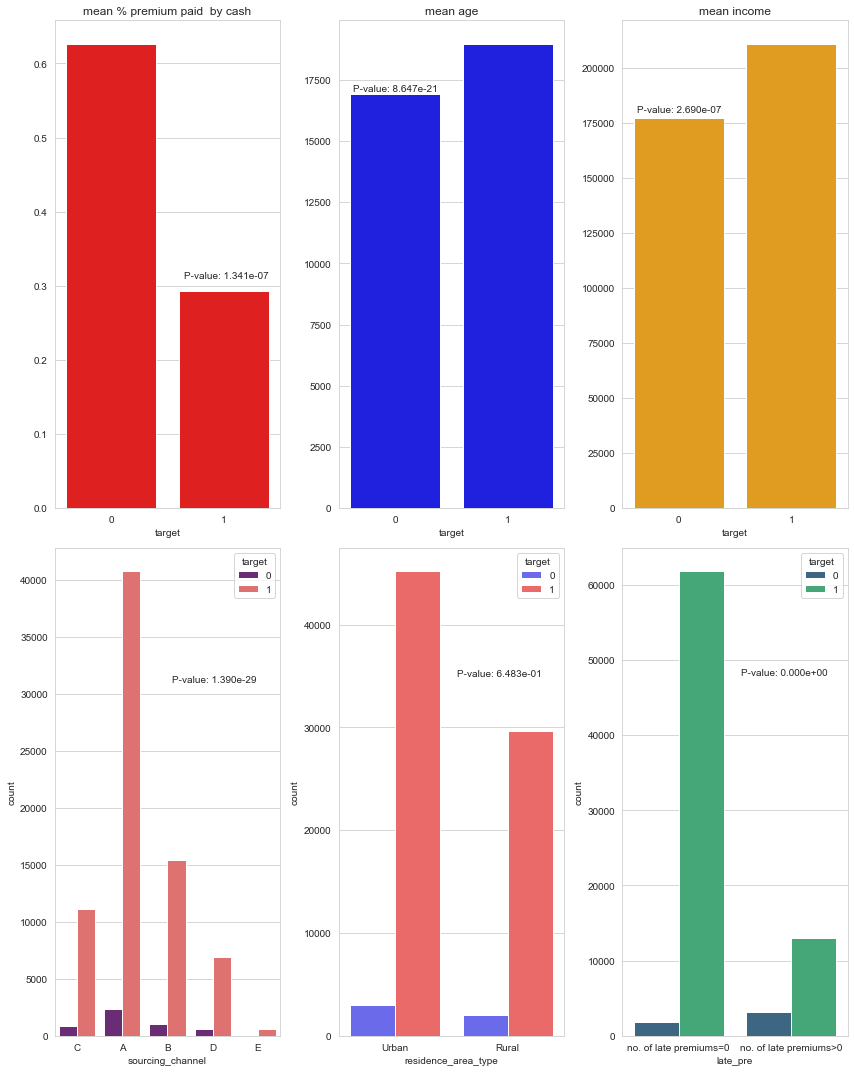

In [5]:
from scipy import stats

def ttest(label):
    
    '''
    used to check any significant relationship b/w random sample of a continuous and categorical (target) 
    variable
    
    inputs-- 
        label: which feature to compare to w.r.t target variable
    
    output--
        p: P-value
    '''
    
    a= np.random.choice(train_[label],20)
    b= np.random.choice(train_['target'],20)
    t,p= stats.ttest_ind(a,b)
    
    return p

def chi2test(label,train=train_):
    
    '''
    performs the chi square test b/w a categorical and another categorical(target) variable
    
    input --
      label: the variable to test for statistical significance against the target variable.
        
    output --
      chi2: the chi square score
    '''
    
    df= pd.crosstab(train[label], train.target) #creates a frequency table
    chi2= stats.chi2_contingency(df)[1]
    
    return chi2

fig= plt.figure(figsize= (12,15))

ax1= fig.add_subplot(2,3,1)
ax2= fig.add_subplot(2,3,2)
ax3= fig.add_subplot(2,3,3)
ax4= fig.add_subplot(2,3,4)
ax5= fig.add_subplot(2,3,5)
ax6= fig.add_subplot(2,3,6)

sns.barplot(train_.groupby(['target'])['perc_premium_paid_by_cash_credit'].mean().index,train_.groupby(['target'])['perc_premium_paid_by_cash_credit'].mean().values,color= 'red',ax= ax1)
sns.barplot(train_.groupby(['target'])['age_in_days'].mean().index,train_.groupby(['target'])['age_in_days'].mean().values,color= 'blue',ax= ax2)
sns.barplot(train_.groupby(['target'])['Income'].mean().index,train_.groupby(['target'])['Income'].mean().values,color= 'orange',ax= ax3)

ax1.set_title('mean % premium paid  by cash')
ax2.set_title('mean age')
ax3.set_title('mean income')

ax1.annotate('P-value: {:.3e}'.format(ttest('perc_premium_paid_by_cash_credit')),(0.65,0.31))
ax2.annotate('P-value: {:.3e}'.format(ttest('age_in_days')),(-0.37,17020))
ax3.annotate('P-value: {:.3e}'.format(ttest('Income')),(-0.37,180000))

traind= train_.copy()
traind['late_pre']= traind['Count_3-6_months_late']+traind['Count_6-12_months_late']+traind['Count_more_than_12_months_late']
traind['late_pre']= traind['late_pre'].apply(lambda x: 'no. of late premiums>0' if x>0 else 'no. of late premiums=0' ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )

sns.countplot(train_['sourcing_channel'], hue= train_['target'],palette= 'magma',ax= ax4)
sns.countplot(train_['residence_area_type'], hue= train_['target'],palette= 'seismic',ax= ax5)
sns.countplot(traind['late_pre'],hue= traind['target'],palette= 'viridis',ax= ax6)

ax4.annotate('P-value: {:.3e}'.format(chi2test('sourcing_channel')),(2.1,31000))
ax5.annotate('P-value: {:.3e}'.format(chi2test('residence_area_type')),(0.55,35000))
ax6.annotate('P-value: {:.3e}'.format(chi2test('late_pre',traind)),(0.55,48000))

plt.tight_layout()
fig.show()

__we can infer that:__
* *the non-payers tend to pay their premiums more by cash as compared to the payers (__statistically significant as P-val < 0.05__)* 
* *the payers tend to be more aged than the non-payers (maybe because they tend to have more income as more experience in job   over the years) (__statistically significant as P-val < 0.05__)*
* *the payers have relatively greater income as compared to non-payers (__statistically significant as P-val < 0.05__)*
* *the sourcing channel A is significant to the payers as well as non-payers (__statistically significant as P-val < 0.05__)* 
* *the payers as well as the non-payers tend to be more from the urban areas (__statistically insignificant as P-val > 0.05__) may change for specific category after dummification*
* *for no. of late premiums=0 there is a greater number of payers and also the non payers are less as compared to the ones who had late premiums (__statistically significant as P-val < 0.05__)*

# - Bagging and data preprocessing:

* ## train 1

In [266]:
train_1= train[train['perc_premium_paid_by_cash_credit']==0]

train_1.application_underwriting_score.fillna(train_1.application_underwriting_score.mean(), inplace= True)
train_1= pd.concat([train_1,pd.get_dummies(train_1[['sourcing_channel','residence_area_type']])],axis= 1)
train_1['Income']= np.log(train_1['Income'])
train_1['paid_bin']= train_1['no_of_premiums_paid'].apply(lambda x: 1 if x<17 else 0)
train_1['late_pre']= train_1['Count_3-6_months_late']+train_1['Count_6-12_months_late']+train_1['Count_more_than_12_months_late']
train_1['late_pre']= train_1['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
train_1['safety_ratio']= (train_1['Count_3-6_months_late']+train_1['Count_6-12_months_late']+train_1['Count_more_than_12_months_late'])/train_1['no_of_premiums_paid']
train_1= train_1.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type'],axis= 1)

* ## train 21

In [267]:
train_2= train[(train['perc_premium_paid_by_cash_credit'] != 0) & (train['perc_premium_paid_by_cash_credit'] != 1)]
value= train_2.groupby(['sourcing_channel'])['application_underwriting_score'].mean()
train_2.fillna(0, inplace= True)
for ind,sc in zip(train_2.index,train_2.application_underwriting_score):
    for i,val in zip(value.index,value.values):
        if sc== 0:
            if train_2.loc[ind,'sourcing_channel']== i:
                train_2.loc[ind,'application_underwriting_score']= val
train_21= train_2[(train_2['application_underwriting_score']>97.0)]
train_21= pd.concat([train_21,pd.get_dummies(train_21[['sourcing_channel','residence_area_type']])],axis= 1)
train_21['Income']= np.log(train_21['Income'])
train_21['paid_bin']= train_21['no_of_premiums_paid'].apply(lambda x: 1 if x<20 else 0)
train_21['late_pre']= train_21['Count_3-6_months_late']+train_21['Count_6-12_months_late']+train_21['Count_more_than_12_months_late']
train_21['late_pre']= train_21['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
train_21['safety_ratio']= (train_21['Count_3-6_months_late']+train_21['Count_6-12_months_late']+train_21['Count_more_than_12_months_late'])/train_21['no_of_premiums_paid']
train_21= train_21.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)

* ## train 22

In [268]:
train_22= train_2[(train_2['application_underwriting_score']<=97.0)]
train_22= pd.concat([train_22,pd.get_dummies(train_22[['sourcing_channel','residence_area_type']])],axis= 1)
train_22['Income']= np.log(train_22['Income'])
train_22['paid_bin']= train_22['no_of_premiums_paid'].apply(lambda x: 1 if x<22 else 0)
train_22['late_pre']= train_22['Count_3-6_months_late']+train_22['Count_6-12_months_late']+train_22['Count_more_than_12_months_late']
train_22['late_pre']= train_22['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
train_22['safety_ratio']= (train_22['Count_3-6_months_late']+train_22['Count_6-12_months_late']+train_22['Count_more_than_12_months_late'])/train_22['no_of_premiums_paid']
train_22= train_22.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)

* ## train 3 

In [269]:
train_3= train[train['perc_premium_paid_by_cash_credit']==1]

train_3.application_underwriting_score.fillna(train_3.application_underwriting_score.mean(), inplace= True)
train_3.fillna(0,inplace= True)
train_3= pd.concat([train_3,pd.get_dummies(train_3[['sourcing_channel','residence_area_type']])],axis= 1)
train_3['Income']= np.log(train_3['Income'])
train_3['paid_bin']= train_3['no_of_premiums_paid'].apply(lambda x: 1 if x<13 else 0)
train_3['late_pre']= train_3['Count_3-6_months_late']+train_3['Count_6-12_months_late']+train_3['Count_more_than_12_months_late']
train_3['late_pre']= train_3['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
train_3['safety_ratio']= (train_3['Count_3-6_months_late']+train_3['Count_6-12_months_late']+train_3['Count_more_than_12_months_late'])/train_3['no_of_premiums_paid']
train_3= train_3.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)

In [270]:
def ren(df):
    
    df= df[df.columns[0:9].to_list()+ df.columns[10:].to_list()+ ['target']]
    df.drop('id', axis= 1,inplace= True)
    
    return df

train_1,train_21,train_22,train_3= ren(train_1),ren(train_21),ren(train_22),ren(train_3)

# - Model building and evaluation:

In [271]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

* ## Splitting the data into training and test sets:

In [272]:
x1= StandardScaler().fit_transform(train_1.iloc[0:4000,:16]) #4001:5722
y1= train_1.iloc[0:4000,-1]
x21= StandardScaler().fit_transform(train_21.iloc[0:50000,:15]) #50001:67710
y21= train_21.iloc[0:50000,-1]
x22= StandardScaler().fit_transform(train_22.iloc[0:800,:15]) #801:1414
y22= train_22.iloc[0:800,-1]
x3= StandardScaler().fit_transform(train_3.iloc[0:3000,:15]) #3001:5003
y3= train_3.iloc[0:3000,-1]

In [273]:
log1= LogisticRegression(C= 0.1, solver= 'sag').fit(x1,y1)
log21= LogisticRegression(C= 0.1, solver= 'sag').fit(x21,y21)
log22= LogisticRegression(C= 0.1, solver= 'sag').fit(x22,y22)
log3= LogisticRegression(C= 0.1, solver= 'sag').fit(x3,y3)

print(roc_auc_score(y1,log1.predict_proba(x1)[:,1]),roc_auc_score(y21,log21.predict_proba(x21)[:,1]),roc_auc_score(y22,log22.predict_proba(x22)[:,1]),roc_auc_score(y3,log3.predict_proba(x3)[:,1]))

0.7892057617866104 0.8321214587479883 0.8008221993833506 0.773545698456193


In [274]:
x1t= StandardScaler().fit_transform(train_1.iloc[4001:5722,:16]) #4001:5722
y1t= train_1.iloc[4001:5722,-1]
x21t= StandardScaler().fit_transform(train_21.iloc[50001:67710,:15]) #50001:67710
y21t= train_21.iloc[50001:67710,-1]
x22t= StandardScaler().fit_transform(train_22.iloc[801:1414,:15]) #801:1414
y22t= train_22.iloc[801:1414,-1]
x3t= StandardScaler().fit_transform(train_3.iloc[3001:5003,:15]) #3001:5003
y3t= train_3.iloc[3001:5003,-1]

print(roc_auc_score(y1t,log1.predict_proba(x1t)[:,1]),roc_auc_score(y21t,log21.predict_proba(x21t)[:,1]),roc_auc_score(y22t,log22.predict_proba(x22t)[:,1]),roc_auc_score(y3t,log3.predict_proba(x3t)[:,1]))

0.8004109428202418 0.8224902495502091 0.7644114002478314 0.7680346292295495


* ## preprocessing function for the provided test set:

In [275]:
def test_prep2(train):
    
    train_1= train[train['perc_premium_paid_by_cash_credit']==0]
    train_1.application_underwriting_score.fillna(train_1.application_underwriting_score.mean(), inplace= True)
    train_1= pd.concat([train_1,pd.get_dummies(train_1[['sourcing_channel','residence_area_type']])],axis= 1)
    train_1['Income']= np.log(train_1['Income'])
    train_1['paid_bin']= train_1['no_of_premiums_paid'].apply(lambda x: 1 if x<17 else 0)
    train_1['late_pre']= train_1['Count_3-6_months_late']+train_1['Count_6-12_months_late']+train_1['Count_more_than_12_months_late']
    train_1['late_pre']= train_1['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                               # (1 if no. of late premiums>0 else 0 )
    train_1['safety_ratio']= (train_1['Count_3-6_months_late']+train_1['Count_6-12_months_late']+train_1['Count_more_than_12_months_late'])/train_1['no_of_premiums_paid']
    train_1= train_1.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type'],axis= 1)

    
    train_2= train[(train['perc_premium_paid_by_cash_credit'] != 0) & (train['perc_premium_paid_by_cash_credit'] != 1)]
    value= train_2.groupby(['sourcing_channel'])['application_underwriting_score'].mean()
    train_2.fillna(0, inplace= True)
    for ind,sc in zip(train_2.index,train_2.application_underwriting_score):
        for i,val in zip(value.index,value.values):
            if sc== 0:
                if train_2.loc[ind,'sourcing_channel']== i:
                    train_2.loc[ind,'application_underwriting_score']= val
    train_21= train_2[(train_2['application_underwriting_score']>97)]
    train_21= pd.concat([train_21,pd.get_dummies(train_21[['sourcing_channel','residence_area_type']])],axis= 1)
    train_21['Income']= np.log(train_21['Income'])
    train_21['paid_bin']= train_21['no_of_premiums_paid'].apply(lambda x: 1 if x<20 else 0)
    train_21['late_pre']= train_21['Count_3-6_months_late']+train_21['Count_6-12_months_late']+train_21['Count_more_than_12_months_late']
    train_21['late_pre']= train_21['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
    train_21['safety_ratio']= (train_21['Count_3-6_months_late']+train_21['Count_6-12_months_late']+train_21['Count_more_than_12_months_late'])/train_21['no_of_premiums_paid']
    train_21= train_21.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)
    
    train_22= train_2[(train_2['application_underwriting_score']<=97)]
    train_22= pd.concat([train_22,pd.get_dummies(train_22[['sourcing_channel','residence_area_type']])],axis= 1)
    train_22['Income']= np.log(train_22['Income'])
    train_22['paid_bin']= train_22['no_of_premiums_paid'].apply(lambda x: 1 if x<22 else 0)
    train_22['late_pre']= train_22['Count_3-6_months_late']+train_22['Count_6-12_months_late']+train_22['Count_more_than_12_months_late']
    train_22['late_pre']= train_22['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
    train_22['safety_ratio']= (train_22['Count_3-6_months_late']+train_22['Count_6-12_months_late']+train_22['Count_more_than_12_months_late'])/train_22['no_of_premiums_paid']
    train_22= train_22.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)
    
    
    train_3= train[train['perc_premium_paid_by_cash_credit']==1]
    train_3.application_underwriting_score.fillna(train_3.application_underwriting_score.mean(), inplace= True)
    train_3.fillna(0,inplace= True)
    train_3= pd.concat([train_3,pd.get_dummies(train_3[['sourcing_channel','residence_area_type']])],axis= 1)
    train_3['Income']= np.log(train_3['Income'])
    train_3['paid_bin']= train_3['no_of_premiums_paid'].apply(lambda x: 1 if x<10 else 0)
    train_3['late_pre']= train_3['Count_3-6_months_late']+train_3['Count_6-12_months_late']+train_3['Count_more_than_12_months_late']
    train_3['late_pre']= train_3['late_pre'].apply(lambda x: 1 if x>0 else 0 ) # binning the total late premiums 
                                                                       # (1 if no. of late premiums>0 else 0 )
    train_3['safety_ratio']= (train_3['Count_3-6_months_late']+train_3['Count_6-12_months_late']+train_3['Count_more_than_12_months_late'])/train_3['no_of_premiums_paid']
    train_3= train_3.drop(['sourcing_channel','sourcing_channel_C','sourcing_channel_B','residence_area_type','residence_area_type_Rural'],axis= 1)
    
    x_test1= StandardScaler().fit_transform(train_1.iloc[:,1:])
    x_test21= StandardScaler().fit_transform(train_21.iloc[:,1:])
    x_test22= StandardScaler().fit_transform(train_22.iloc[:,1:])
    x_test3= StandardScaler().fit_transform(train_3.iloc[:,1:])
    
    return (x_test1,x_test21,x_test22,x_test3,train_1,train_21,train_22,train_3)

In [276]:
x_test1,x_test21,x_test22,x_test3,t1,t21,t22,t3 = test_prep2(test)

# - Making final predictions and converting into the required submission format:

In [277]:
pred1= log1.predict_proba(x_test1)
pred21= log21.predict_proba(x_test21)
pred22= log22.predict_proba(x_test22)
pred3= log3.predict_proba(x_test3)

In [278]:
sub1= pd.DataFrame()
sub21= pd.DataFrame()
sub22= pd.DataFrame()
sub3= pd.DataFrame()
sub1['id']= t1['id']
sub21['id']= t21['id']
sub22['id']= t22['id']
sub3['id']= t3['id']
sub1['target']= pred1[:,1]
sub21['target']= pred21[:,1]
sub22['target']= pred22[:,1]
sub3['target']= pred3[:,1]

sub= pd.concat([sub1,sub21,sub22,sub3],axis= 0)
sub.set_index('id',inplace= True)
sub= sub.sort_index()
sub.to_csv('sample_submission_final.csv')